![Sizing Lab](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/Baniere.png)

# TD1/2 - Hydrid storage architecture & specification

*Written by Marc Budinger, INSA Toulouse, France*

We will consider here an hybrid solution with super capacitors and traction batteries packs. This notebook is dedicated to :
- understand main operating limits of super capacitors and batteries;
- understand a control architecture enabling to split power between super capacitors and batteries;
- specify energy storage requirements of the different energy sources.

The storage element selection approach developed here is inspired by the following publication:
> Jaafar, A., Sareni, B., Roboam, X., & Thiounn-Guermeur, M. (2010, September). Sizing of a hybrid locomotive based on accumulators and ultracapacitors. In 2010 IEEE Vehicle Power and Propulsion Conference (pp. 1-6). IEEE [[pdf](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/papers/Sizing_of_a_hybrid_locomotive_based_on_accumulators_and_ultracapacitors.pdf)].

## Main operating limits of energy storage components

To select the energy storage means, it is necessary to understand their main operational limits which can be representative of:
- **rapid/quick deterioration** that can develop over an short operating cycle (minutes/hours).  
- **gradual degradation** linked to the lifespan of the component over multiple cycles (months/years), where the accumulation of degradation leads to an irreversible loss of performance.  

> **Questions 1:** Examine the following Figures extracted from a datasheet of elementary [supercapacitors](https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf) cell or [battery (LiFeSO4)](https://5.imimg.com/data5/SELLER/Doc/2021/3/VO/ZR/QG/86781150/3-2-v-10-ah-lifepo4-prismatic-cell.pdf) cell. Propose selection criteria representative of the main operational limits. Explain how to take into account an high number of [discharge cycles](https://www.powertechsystems.eu/home/tech-corner/lithium-iron-phosphate-lifepo4/) within the sizing process of a battery.

![Battery Cell](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/BatteryCellEXample.png)

![Ultracapacitor Cell](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SCCellExample.png)


## Reflexion on the Watt System architecture (capacitors)

The [WATT system](http://www.pvi.fr/wattsystem-watt-system,172.html) includes:
- In the bus: a battery pack and an ultra capacitors pack integrated to the electric power train, a connection system with an automatic arm installed on the roof of the vehicle;
- On the sidewalk: a charging station or "totem" with the connection, as well as a pack of super capacitors, all integrated in the urban landscape.

Each totem (or charging station) is connected to the household electricity distribution network and allows charging between the stop of each bus. 

In operation the bus is powered by supercapacitors, it travels the necessary distance to the next stop, thanks to the energy stored.
At each stop, the arm deploys and realizes in 10 seconds the transfer of energy between the super capacitors of the totem and the onboard super capacitors.
An adapted Lithium-ion battery pack is installed in the bus in case of a connection or recharge problem and trips without passengers to return to the central station (maintenance).

*Ultracapacitor Pack and Totem*
![PositionPacks](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/PositionPacks.png)


In order to estimate the dimensions of the ultracapacities pack, we will be interested in the energy to be supplied to the motorization of the bus on a typical path:
- Top speed $v_{max}$ = 30 km/h
- Distance between 2 totems $d$ = 800 m
- Maximum height difference $h$ = 3 m

The bus has the following characteristics:
- Mass with passengers $m$ = 20 t
- [Rolling coefficient](http://en.wikipedia.org/wiki/Rolling_resistance) tires $C_{rr}$= 0.01

Aerodynamic effect are assume here to be negligeable due to low speed.

 > Exercice 1: Write the general equation enabling to calculate the maximum energy to supply (to be stored). Apply it with considered simplification (aerodynamics neglected) for defined use case scenario.

In [1]:
# Parameters
v_max=30*1000/3600 # [m/s] max speed
m=20e3 # [kg] bus mass
d=800. # [m] distance
h=3. # [m] rise height
C_rr= 0.01 # [-] tyre rolling coef
g=9.81 # [m/s²] gravity acceleration

# Energies & works calculations
E_k=1/2*m*v_max**2 # [J] kinetic energy
E_g=m*h*g # [J] potential gravity energy
W_r=m*g*C_rr*d # [J] friction work of rolling coef
E_t=E_k+E_g+W_r # [J] Total energy for 1 travel

print("Kinetic energy   : %.2g J"%E_k)
print("Potential energy : %.2g J"%E_g)
print("Friction work    : %.2g J"%W_r)
print("Total energy     : %.2g J"%(E_t))

Kinetic energy   : 6.9e+05 J
Potential energy : 5.9e+05 J
Friction work    : 1.6e+06 J
Total energy     : 2.9e+06 J


We will take as ultra-capacitor reference  the following [module](http://www.maxwell.com/products/ultracapacitors/125v-tran-modules) from [Maxwell Technologies](http://www.maxwell.com). 

*Maxwell module characteristics*
![MaxwellModule](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/MaxwellModule.png)

> Exercice 2: We will assume that maximum discharge is reached when capacitor voltage reaches half its naximum voltage. Explain and calculate the minimum number of modules.

In [2]:
import math

# Maxwell module characteristics
V_max=125. # [V] Max voltage
C=63. # [F] Module capacitance

# Modules number calculation
V_min=V_max/2
E_1mod=1/2*C*(V_max**2-V_min**2)
N_mod=math.ceil(E_t/E_1mod)
print("Number of 125 V - 63 F modules :",N_mod)

Number of 125 V - 63 F modules : 8


## Simulation of a complete line

The objective of this section is to propose an evolution of the previous python codes to be able to:
- simulate the power profile necessary for a complete line comprising several sections.
> - *We will define in particular the type of vehicle, the different lengths of sections between 2 stations (Distances vector), the average speed to be ensured (Speeds vector), the presence of charger in station (Chargers vector), the stopping duration at station (StopDuration vector), the ratio between the maximum braking power and the maximum acceleration power (RatioBrakeMax).*
- provide the information necessary for sizing the battery/supercapacity packs that could be added.
> - *We assume here an efficiency of the motorization chain of 100%.*
> - *Each line section will be optimized in order to meet the requirements defined previously and minimize the energy consumed.*
> -*The energy flow or the resulting power demand will be shared between battery and supercapacity with control based on frequency sharing of demands: the low frequency power will be provided by the batteries while the high frequency part will be provided by supercapacitors.*
> - *Indicators useful for sizing will then be generated from these power profiles.*

- take into account the energy that could come from charging stations or catenaries.
> - *This version will only implement the consideration of charging stations.*
> - *Each charging station will provide the power to compensate for the energy of the travel from the last station.*

Let us first load the classes developed within TP1 notebook.

In [3]:
%%capture
%run ./01b_CaseStudy_Specification.ipynb

Here we define a `line` class with all the functionalities described just before.

In [4]:
from scipy import signal

class line():
    def __init__(self, Vehicle, Distances, Speeds, Chargers, StopDuration, RatioBrakeMax):
        
        # Save attributes
        self.Chargers =  Chargers # Boolean vector (True = Charger, False = No Charger , at the end of the section)
        self.StopDuration = StopDuration # [s] station stop duration (scalar)
        self.RatioBrakeMax = RatioBrakeMax # [-] Ratio between max braking power / max acceleration power
        
        # Initialization of  transient evolution (vectors)
        self.PowerStorage = [] # Transient evolution of requested power
        self.GlobalTime = [] # Time vector for plot and energy integration
        self.GlobalNRJStorage = [] # Transient evolution of energy
        self.PowerLF = [] # Transient evolution of power  (Low Frequency)
        self.PowerHF = [] # Transient evolution of power  (high Frequency)
        self.LFNRJStorage = [] # Time vector for plot and energy integration (Low Frequency)
        self.HFNRJStorage  =[] # Time vector for plot and energy integration (High Frequency)
        self.TotalLineDistance = sum(Distances)
        self.dt=0.25 # Time step for numerical integration
        
        # Print characteristics of each section
        i=0
        self.Section=[]
        for d,s,c in zip(Distances, Speeds, Chargers):
            print("Section %.i: %.i m at %.2f m/s %s charger"%(i+1,d,s, "whith" if c else "without"))
            self.Section=self.Section+[OptimSection(Vehicle,d,s,self.RatioBrakeMax,self.dt)]
            i=i+1
    
    # Optimization loop of each section
    def optimLine(self):
        X=[0.1, 1.0, 0.9]
        for i in range(len(self.Section)):
            self.Section[i].optimizeConso_genetic(X)
    
    # Power vector concatenation 
    def CalculPowerStorage(self):
        NRJ = 0
        self.PowerStorage= []
        self.GlobalTime= []
        dt=self.dt # [s] pas de temps pour l'integration
        
        # Power vector build thanks concatenation 
        for i in range(len(self.Section)):
            NRJ=NRJ+self.Section[i].NRJsection[-1] # we add here the energy consummed on the section
            
            self.PowerStorage = self.PowerStorage + self.Section[i].psection
            
            # Chargers effect
            if (self.Chargers[i] == True and i<(len(self.Section)-1)):
                tcharge=NRJ/self.Section[i].Vehicle.Pmax # Charging time caculation function of energy  
            else:
                tcharge=0
            if (tcharge>=self.StopDuration):
                self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                NRJ=0
            else:
                if (i<(len(self.Section)-1)):
                    self.PowerStorage = self.PowerStorage + [-self.Section[i].Vehicle.Pmax]*int(tcharge/dt)
                    self.PowerStorage = self.PowerStorage + [0]*int((self.StopDuration-tcharge)/dt)
                if (self.Chargers[i] == True) :
                    NRJ=0  
        
        # Time vector
        t=0
        for i in range(len(self.PowerStorage)):
            self.GlobalTime = self.GlobalTime + [t]
            t = t + dt
            
    # Filtering of total power in order to generate LF (battery) and HF (capacitor) powers
    def FilterPower(self, omega):
        TF=signal.TransferFunction([1], [1/omega**2, 2*1/omega, 1])
        time, self.PowerLF, state = signal.lsim(TF, self.PowerStorage , self.GlobalTime)
        self.PowerHF = self.PowerStorage -  self.PowerLF
        
    # NRJ vector integration from power vectors
    def IntegrateNRJ(self):
        t=0
        NRJtotal=0
        NRJHF=0
        NRJLF=0
        #NRJTotalAging=0
        #NRJLFAging=0
        self.HFNRJStorage = []
        self.GlobalNRJStorage = []
        self.LFNRJStorage = []
        dt=self.dt
        
        for i in range(len(self.PowerStorage)):
            self.GlobalNRJStorage = self.GlobalNRJStorage + [NRJtotal]
            self.HFNRJStorage = self.HFNRJStorage + [NRJHF]
            self.LFNRJStorage = self.LFNRJStorage + [NRJLF]
            #self.TotalNRJAging = self.TotalNRJAging + [NRJTotalAging]
            #self.LFNRJAging = self.LFNRJAging + [NRJLFAging]
        
            t = t + dt
            NRJtotal = NRJtotal+(self.PowerStorage[i])*dt
            NRJHF = NRJHF+(self.PowerHF[i])*dt
            NRJLF = NRJLF+(self.PowerLF[i])*dt
        
        PmaxHF = max(abs(min(self.PowerHF)),max(self.PowerHF))/1e3 # kW
        PmaxLF = max(self.PowerLF)/1e3 # kW 
        PmaxBrakeLF = abs(min(self.PowerLF))/1e3 # kW, Max power braking
        NRJHF = (max(self.HFNRJStorage) - min(self.HFNRJStorage))/3600/1e3 # NRJ en kWh
        NRJLF = (max(self.LFNRJStorage) - min(self.LFNRJStorage))/3600/1e3 # NRJ en kWh
        
        return PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF
                      
    # Plot the results for a local section
    def plot_power_share(self):
        fig, axs = plt.subplots(2,1)
        try:
            axs[0].plot(self.GlobalTime,self.PowerStorage,'b-',label='Total')
            axs[0].plot(self.GlobalTime,self.PowerLF,'r-.',label='LF')
            axs[0].plot(self.GlobalTime,self.PowerHF,'g-.',label='HF')
        except:
            pass
        axs[0].set_ylabel("Power (W)")
        axs[0].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        axs[0].grid()
        try:
            axs[1].plot(self.GlobalTime,self.GlobalNRJStorage,'b-',label='Total')
            axs[1].plot(self.GlobalTime,self.LFNRJStorage,'r-.',label='LF')
            axs[1].plot(self.GlobalTime,self.HFNRJStorage,'g-.',label='HF')
            axs[1].set_ylabel("Energy (J)")
            axs[1].legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
            axs[1].grid()   
            axs[1].set_xlabel('Time (s)')
        except:
            fig.delaxes(axs[1])
        fig.tight_layout() 

    # Plot the results for the complete line
    def plot_sections(self):
        for i in range(len(self.Section)):
            self.Section[i].plot()  
              
            

> Exercice 3: Read previous code and explain what it does method by method.

## Example of a line definition

We can now use this new class to define a bus transport line with the following requirements:
- distances: 700, 500, 400, 700, 300, 300, 300, 300, 300, 300 m/s
- mean speed: 7, 7, 7, 5, 5, 5, 5, 5 m/s
- one final charger

 > Exercice 4: Define the line and launch an optimization process. Then plot the results on all the profiles.

In [5]:
ToulouseC=line(Bus, [700,500,400,700,300,300,300,300,300], [7,7,7,5,5,5,5,5], [False,False,False,False,False,False,False,True], 20, 0.6)

Section 1: 700 m at 7.00 m/s without charger
Section 2: 500 m at 7.00 m/s without charger
Section 3: 400 m at 7.00 m/s without charger
Section 4: 700 m at 5.00 m/s without charger
Section 5: 300 m at 5.00 m/s without charger
Section 6: 300 m at 5.00 m/s without charger
Section 7: 300 m at 5.00 m/s without charger
Section 8: 300 m at 5.00 m/s whith charger


In [6]:
ToulouseC.optimLine()

             message: Optimization terminated successfully.
             success: True
                 fun: 1.079040586522512
                   x: [ 5.002e-02  8.171e-01  9.689e-01]
                 nit: 15
                nfev: 724
          population: [[ 5.002e-02  8.171e-01  9.689e-01]
                       [ 5.139e-02  8.870e-01  9.226e-01]
                       ...
                       [ 5.779e-02  8.323e-01  9.745e-01]
                       [ 5.688e-02  8.564e-01  8.807e-01]]
 population_energies: [ 1.079e+00  1.088e+00 ...  1.090e+00  1.087e+00]
             message: Optimization terminated successfully.
             success: True
                 fun: 1.0896754785265654
                   x: [ 7.737e-02  7.882e-01  9.876e-01]
                 nit: 11
                nfev: 544
          population: [[ 7.737e-02  7.882e-01  9.876e-01]
                       [ 8.282e-02  9.415e-01  8.189e-01]
                       ...
                       [ 7.161e-02  8.880e-01  9.653e-

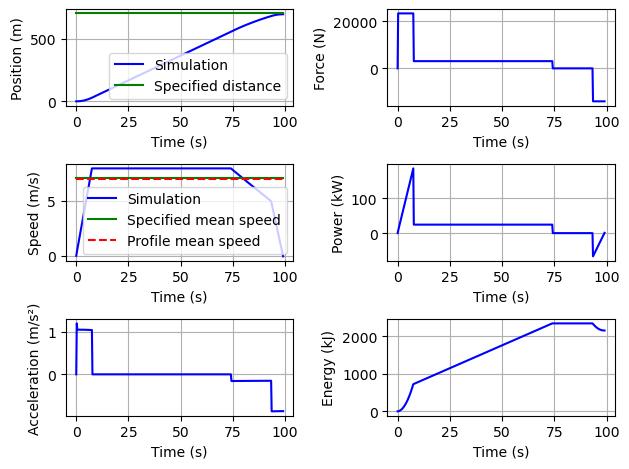

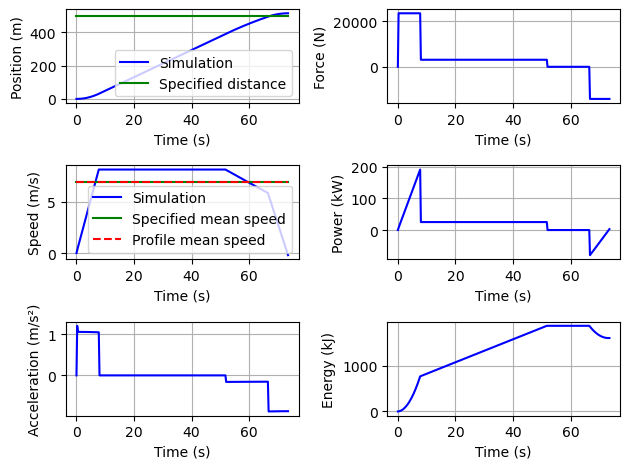

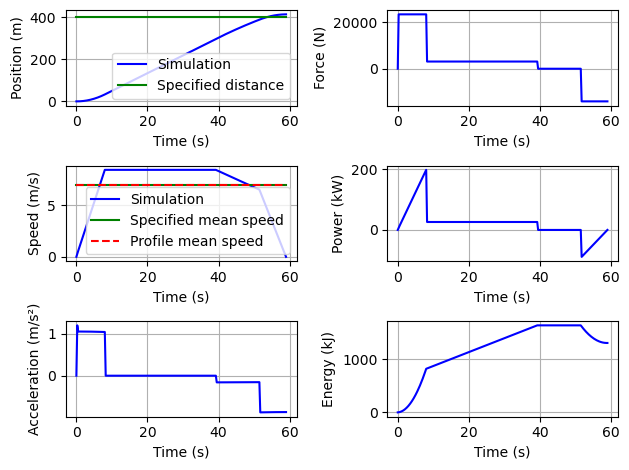

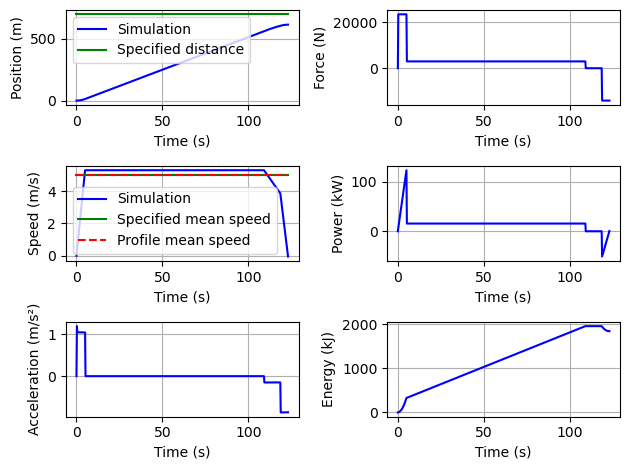

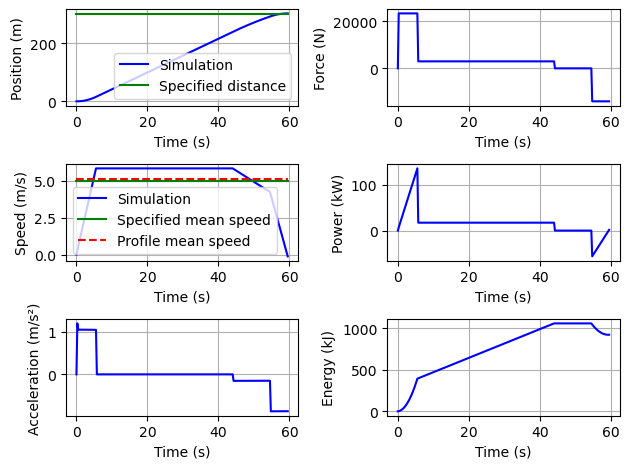

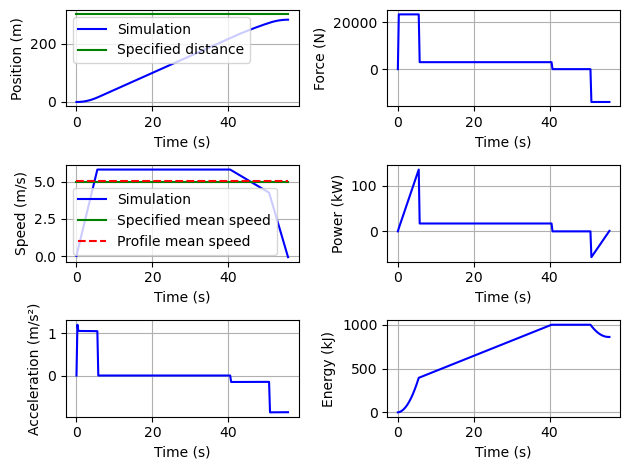

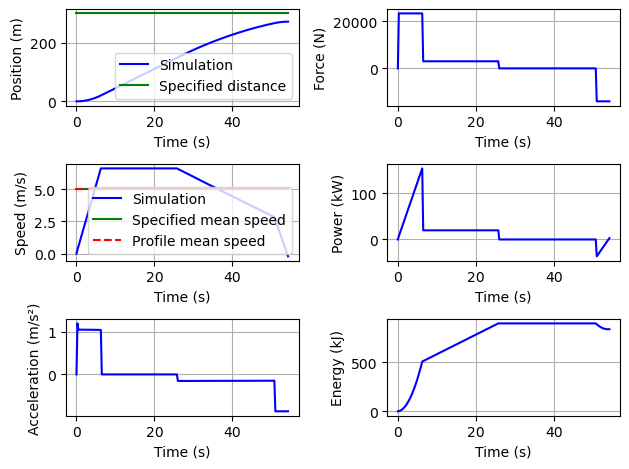

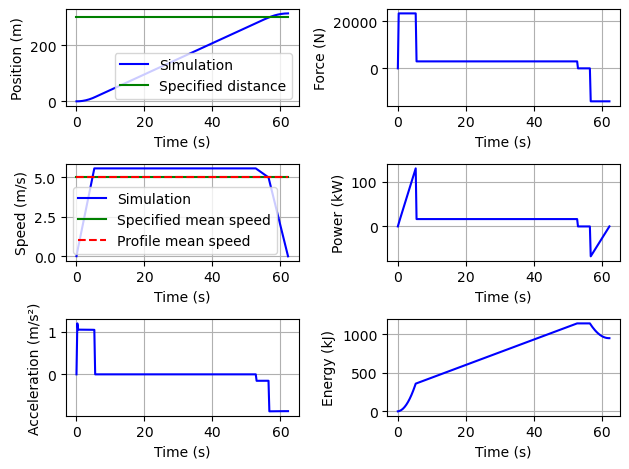

In [7]:
ToulouseC.plot_sections()

A time vector of evolution of the power required at each section or supplied to each charger is constructed.

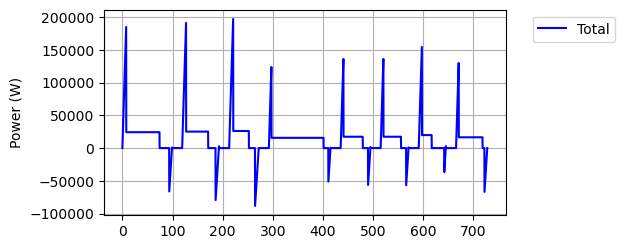

In [8]:
ToulouseC.CalculPowerStorage()
ToulouseC.plot_power_share()

## Hybrid storage system sizing

The energy flow or the resulting power demand will be shared between battery and supercapacity with control based on frequency sharing of demands. The Figure below shows how the low frequency power will be provided by the batteries while the high frequency part will be provided by supercapacitors.

![Sizing Stategy](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/EnergyManagment.png)

The cutoff frequency defines the power sharing and has a strong influence on the sizing of the storage elements. The following code analyzes this power sharing by varying this cutoff frequency.

> Exercice 5: Implement the different sizing criteria (power, energy, lifetime...) to evaluate the mass or CO2 impact of batteries and supercapacitors using emission densities (ratio between CO2 to produce components an their own embedded mass).

In [9]:
omegaV=np.logspace(-5,2,50)
MassStorageV=[]
MassLFPAgeing=[]
MassLFPNRJ=[]
MassLFPPow=[]
MassSCNRJ=[]
MassSCPow=[]
CO2Total=[]

# Lifetime of the vehicle
Targetkm = 250e3 # [km]

# Supercapacitors energy density
# https://1188159.fs1.hubspotusercontent-na1.net/hubfs/1188159/02-DS-220909-SKELCAP-CELLS-1F.pdf
# chez Skeleton
WmassSC=6.8*0.75 # [Wh/kg] 75% of the fully-charge energy can be used (voltage variation from Vmax to Vmax/2)
PmassSC=860/4.3*6.8*0.75 # [W/kg]

# Batteries energy density (LFP technology)
WmassLFP= 100 # [Wh/kg] Depth Of Discharge (DOD) of 100% does not decrease that much the lifetime
PmassLFP=3*100 # [W/kg]  Power density (3C acceptable discharge)
PBmassLFP=1*100 # [W/kg]  Power density (1C acceptable charge)
Ncycle = 3000 # [-] cycles number at 100% DOD

# Bilan carbone
CO2SC = 39 # kgCO2eq/kg d'ecoInvent
CO2LFP = 11 # kgCO2eq/kg d'ecoInvent

# For each LF/HF repartition size batteries/supercapacitors
for omega in omegaV:
    
    ToulouseC.FilterPower(omega)
    PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF = ToulouseC.IntegrateNRJ()

    # Calculate batteries mass depending on criteria (Ageing, energy, power)
    Nc=Targetkm*1000/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
    DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km
    MassLFPAgeing = MassLFPAgeing + [NRJLF*1e3/DoD/WmassLFP]
    MassLFPNRJ = MassLFPNRJ + [NRJLF*1e3/WmassLFP]
    MassLFPPow = MassLFPPow + [max(PmaxLF*1e3/PmassLFP, PmaxBrakeLF*1e3/PBmassLFP)]

    # Calculate capacitors mass depending on criteria (Energy, power)
    MassSCNRJ = MassSCNRJ + [NRJHF*1e3/WmassSC]
    MassSCPow = MassSCPow + [PmaxHF*1e3/PmassSC]

    # Calculate worst case total hybrid storage mass
    MassStorageV = MassStorageV + [max(MassLFPAgeing[-1], MassLFPNRJ[-1], MassLFPPow[-1]) + max(MassSCNRJ[-1], MassSCPow[-1])]
     
    # Calculate CO2 emission for hybrid mix
    CO2Total = CO2Total + [max(MassSCNRJ[-1], MassSCPow[-1])*CO2SC + max(MassLFPAgeing[-1], MassLFPNRJ[-1], MassLFPPow[-1])*CO2LFP]


The following figures represent the overall mass of the solutions according to the choosen power share. A simple CO2 impact is also estimated.

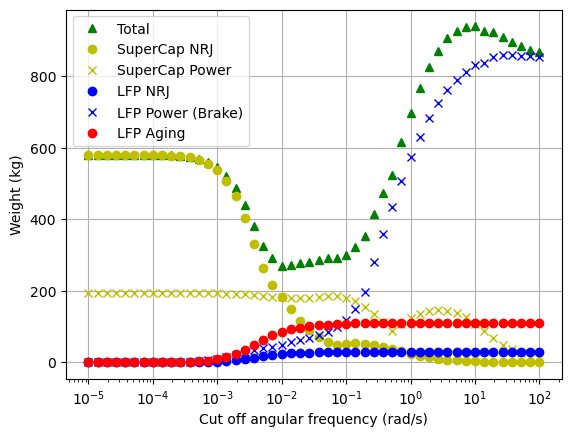

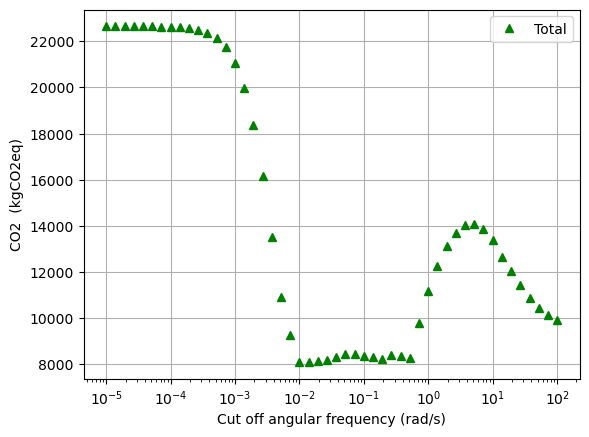

In [10]:
plt.plot(omegaV, MassStorageV, 'g^', label='Total')
plt.plot(omegaV, MassSCNRJ, 'yo', label='SuperCap NRJ')
plt.plot(omegaV, MassSCPow, 'yx', label='SuperCap Power')
plt.plot(omegaV, MassLFPNRJ, 'bo', label='LFP NRJ')
plt.plot(omegaV, MassLFPPow, 'bx', label='LFP Power (Brake)')
plt.plot(omegaV, MassLFPAgeing, 'ro', label='LFP Aging')
plt.xscale('log') 
plt.ylabel('Weight (kg)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.grid()
plt.show()

plt.plot(omegaV, CO2Total, 'g^', label='Total')
plt.xscale('log') 
plt.ylabel('CO2  (kgCO2eq)')
plt.xlabel('Cut off angular frequency (rad/s)')
plt.legend()
plt.grid()
plt.show()

A [Pareto front](https://en.wikipedia.org/wiki/Pareto_front) can help find a solution achieving a compromise between 2 objectives.

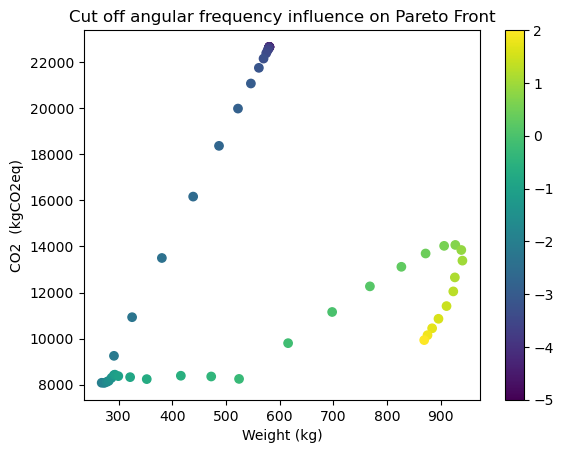

In [11]:
# Pareto Front

plt.scatter(MassStorageV, CO2Total, c=np.log10(omegaV))
plt.xlabel('Weight (kg)')
plt.ylabel('CO2  (kgCO2eq)')
plt.colorbar()
plt.title('Cut off angular frequency influence on Pareto Front')
plt.show()

Super Capacitor:
Pmax: 109.73 kW
NRJ:  0.22 kWh
Mass:  107.6 kg
---
Traction battery:
Pmax discharge: 99.95 kW
Pmax charge: 37.64 kW
NRJ: 11.01 kWh
NRJ one travel: 2.96 kWh
Mass:  376.4 kg
Mass (brake criteria):  333.2 kg
---


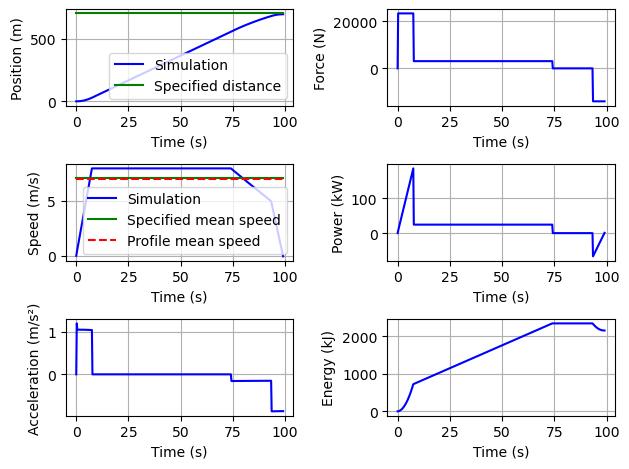

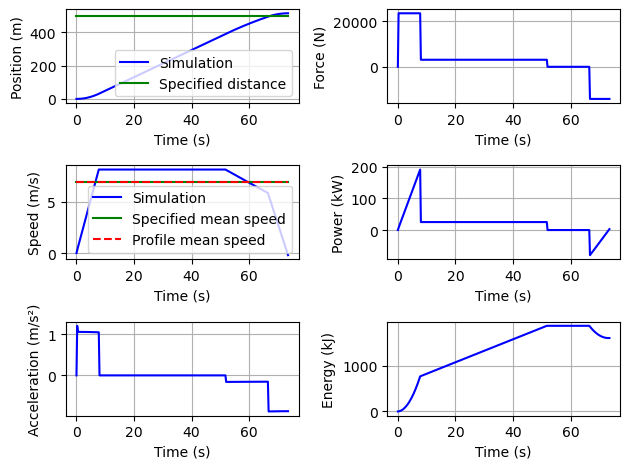

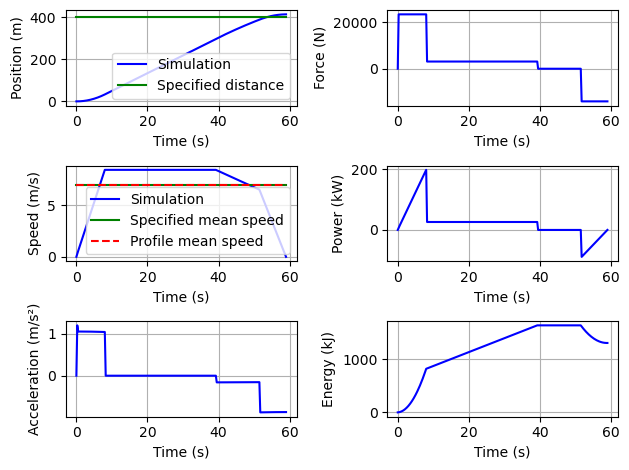

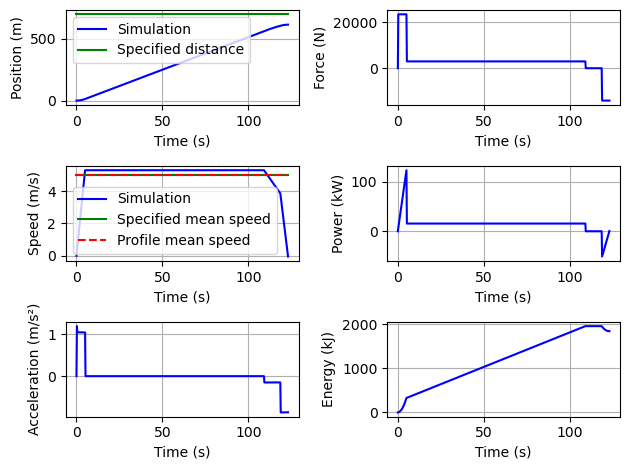

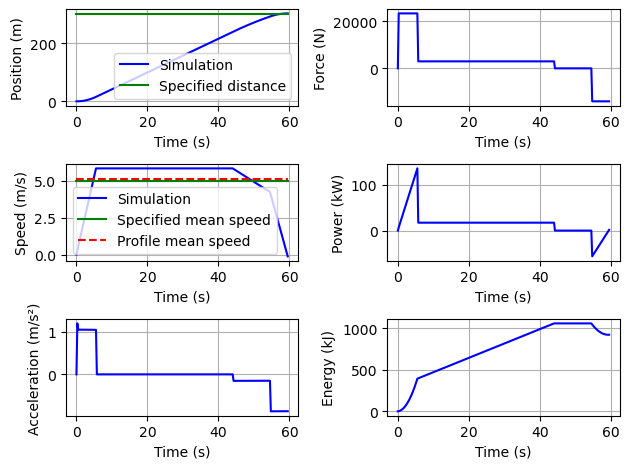

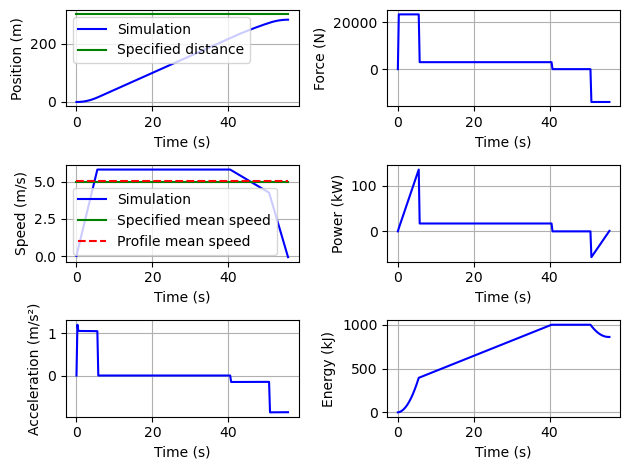

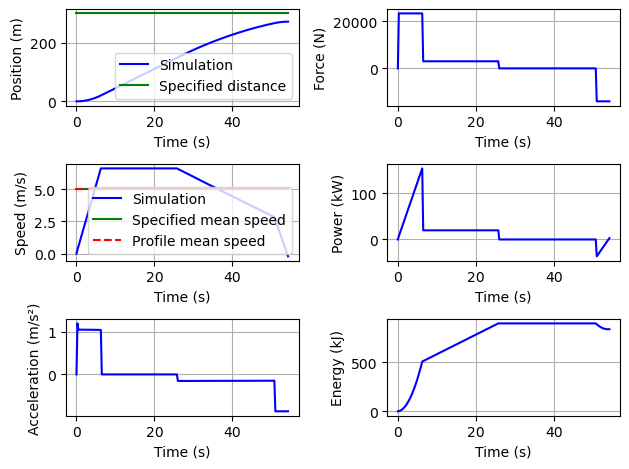

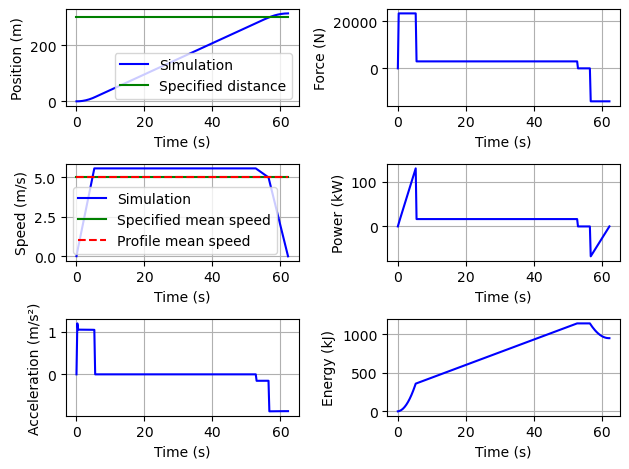

In [13]:
ToulouseC.FilterPower(0.4)
PmaxHF, PmaxLF, PmaxBrakeLF, NRJHF, NRJLF=ToulouseC.IntegrateNRJ()

Nc=Targetkm*1000/ToulouseC.TotalLineDistance # Number of cycles for global lifetime 
DoD=(Nc/3365)**(-1/2.26) # DoD calculation for Target Km

print("Super Capacitor:")
print("Pmax: %.2f kW"%PmaxHF)
print("NRJ:  %.2f kWh"%NRJHF)
print("Mass: % .1f kg"%(max(NRJHF/WmassSC*1e3, PmaxHF/PmassSC*1e3)))
      
print("---")
print("Traction battery:")
print("Pmax discharge: %.2f kW"%PmaxLF)
print("Pmax charge: %.2f kW"%PmaxBrakeLF)
print("NRJ: %.2f kWh"%(NRJLF/DoD))
print("NRJ one travel: %.2f kWh"%(NRJLF))
print("Mass: % .1f kg"%(max(NRJLF/DoD/WmassLFP*1e3,
                                       PmaxLF/PmassLFP*1e3, PmaxBrakeLF/PBmassLFP*1e3)))  
print("Mass (brake criteria): % .1f kg"%(PmaxLF/PmassLFP*1e3))  


ToulouseC.plot_sections()
print("---")

### Labwork and homework

Your objective is to specify the hybrid storage system of an electric bus for doubling line 78 between the IUT Rangueil and MFJA stations.
The characteristics of the bus are [here](https://www.bluebus.fr/bluebus-6-metres)  
![BlueBus](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/bluebus.png)
A example of time table of the line 78 is [here](https://www.tisseo.fr/sites/default/files/fh/ligne78.html)  
![L78](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/L78.PNG)
We will assume a round trip in 20 min, charge at the ends of the lines included.  

> Modify the present notebooks in order to set up a technical justification report : starting from the need (journey, vehicle size, frequency of journeys), setting up the effort/speed/power profiles, the power distribution in the hybrid storage system, the preliminary sizing and the specification of the main components.  

> Adapt and complete the sizing process in order to take into account the global efficiency of the converters and storage elments (assumed to be equal to 80%).   

![Sizing process](https://raw.githubusercontent.com/SizingLab/sizing_course/main/laboratories/Lab-watt_project/assets/images/SizingProcessNu.PNG)  

> Propose compatible technological [storage packs](https://www.skeletontech.com/en/supercapacitor-modules) and specify the DC/DC converters (DC bus of 400 V). 

> Provide an electrical architecture diagram ([possible software](https://qelectrotech.org/)) summarizing your main choices:
>- representing the different sources and load of the network.  
>- making it possible to standardize the DC/DC converters used.  
>- allowing reduced functionality to be maintained in the event of a fault on part of the storage elements  



